Missing values in each column:
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64
   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0       

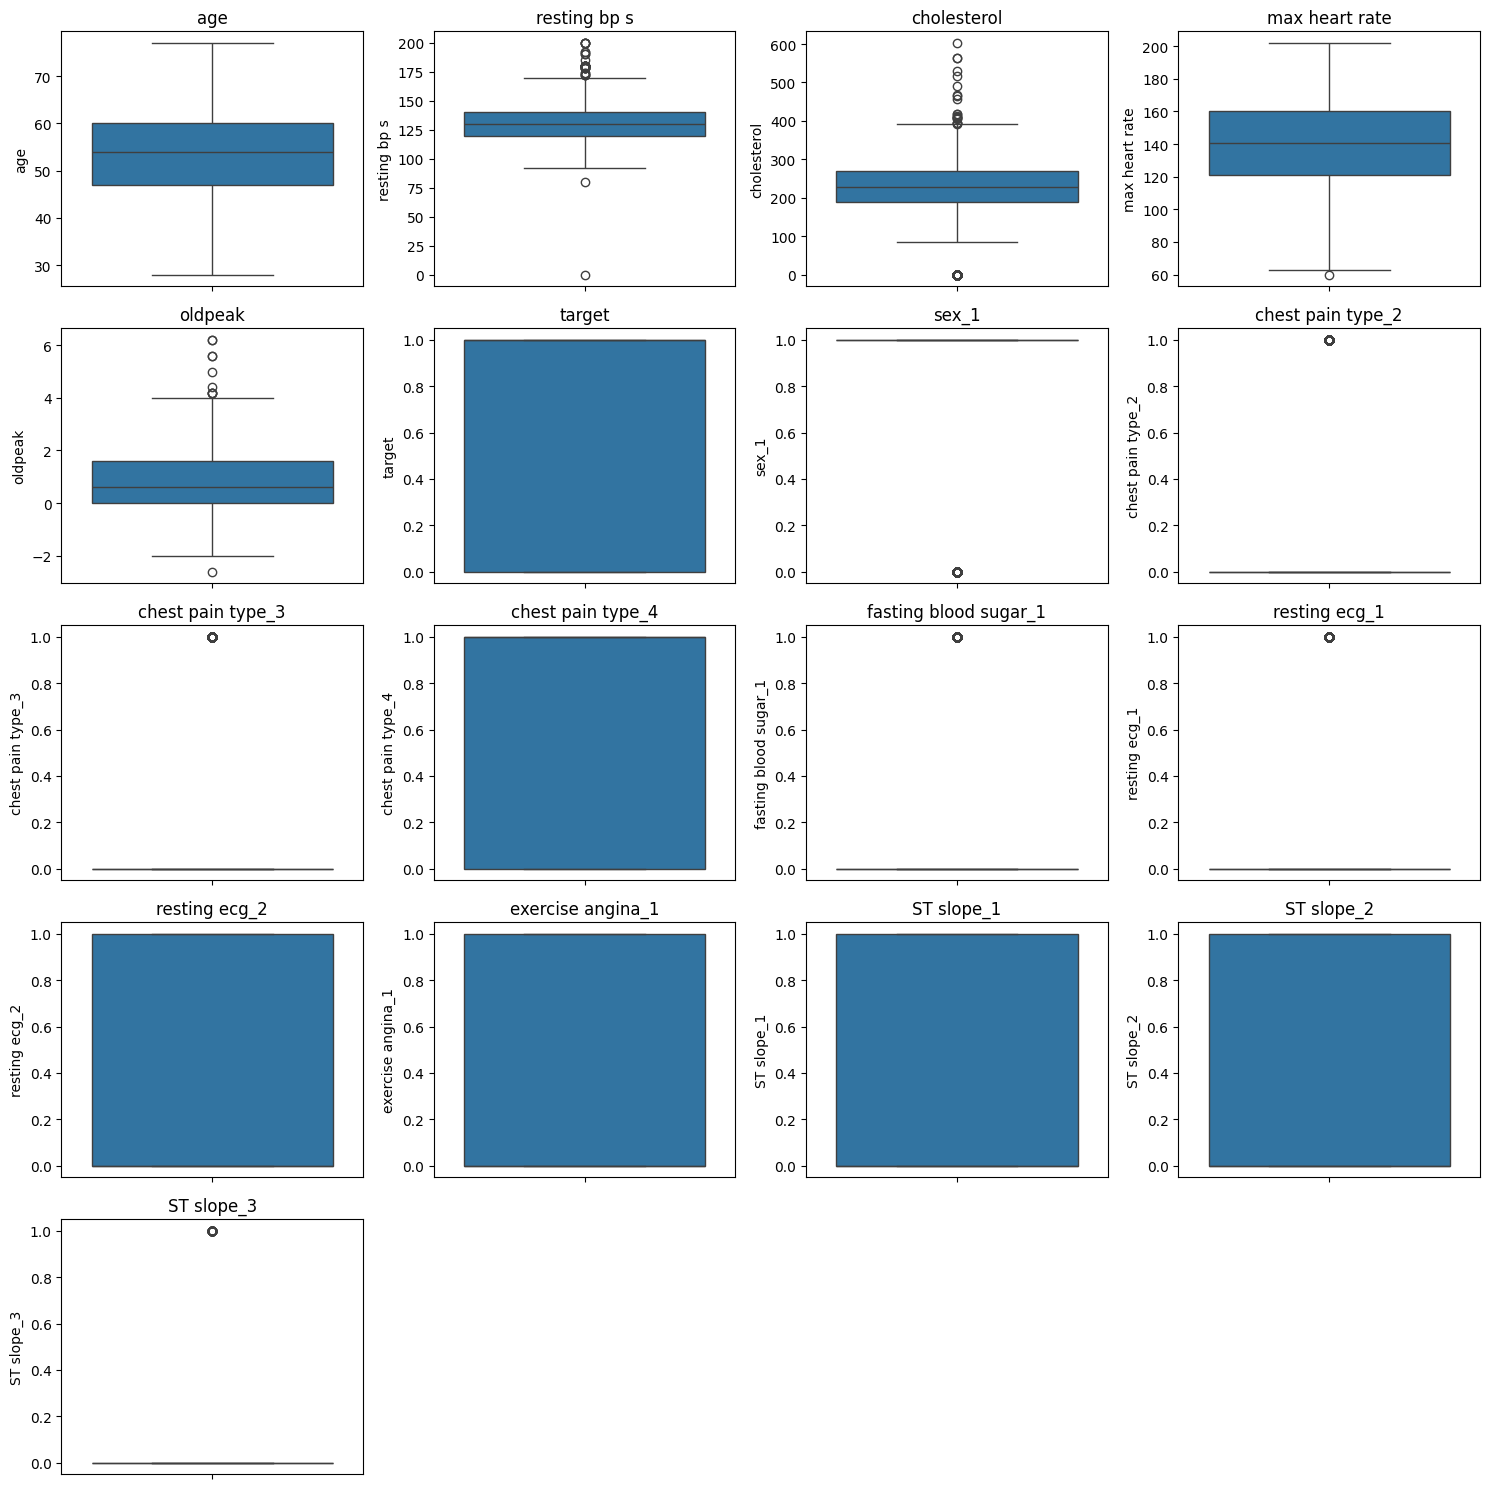

Training set shape: (929, 16), Testing set shape: (233, 16)


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
data = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

# Checking for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Fill missing values with the mean of the column
data.fillna(data.mean(), inplace=True)

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Assuming 'sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', and 'ST slope' are categorical
categorical_columns = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']

# Converting categorical columns to numerical format using one-hot encoding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Ensure all data is numeric
data = data.apply(pd.to_numeric)

# Detecting and handling outliers
# Determine the number of rows and columns for the subplots
num_columns = len(data.columns)
num_rows = (num_columns + 3) // 4  # Adjust for 4 columns per row

# Plotting boxplots to visualize outliers
plt.figure(figsize=(15, num_rows * 3))
for i, column in enumerate(data.columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.boxplot(data[column])
    plt.title(column)
plt.tight_layout()
plt.show()

# Removing outliers using Z-score method
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
data = data[(z_scores < 3).all(axis=1)]

# Separating features and target variable
X = data.drop('target', axis=1)
y = data['target']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Confirm the shapes of the train and test sets
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the model
mlr = LinearRegression()

# Train the model
mlr.fit(X_train, y_train)

# Make predictions
y_pred_mlr = mlr.predict(X_test)
print(y_pred_mlr)

# Evaluate the model
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
print(f'Mean Squared Error for MLR-F: {mse_mlr}')

[ 0.87348402  0.88243861  0.02872154  1.03766384 -0.07846392  0.0064587
  0.84022103  0.09591813  0.0842579   0.94243996  0.96999212  0.60259285
 -0.07846392  0.54183635  0.21580903  0.92896278  0.64792109  0.51134911
  0.46240451 -0.00670556  1.07100101  0.33446742 -0.11574697  0.56131236
  0.79189973  0.38941697  0.69684521  0.43369235  0.60592089  0.21629079
  0.82713039 -0.06328751 -0.14072138  0.67286946  0.87953771  0.30529716
  0.72598778  0.60855171  0.31636826  0.85826482  0.32452305  0.9154278
 -0.00691085  0.97016438  1.01822102  0.16015889  0.94852508  0.32971709
  1.05096027  0.9207981   0.63338421  0.38811158  0.73379199  0.44514026
  0.44096661  0.00570479  0.08061959  1.01493267 -0.10825013  0.63962776
  0.96295302  0.50138788  0.12274643  0.57185696  1.02450171  0.07733502
  0.94974129  0.85574951  0.4303509   0.25835239 -0.07037028  0.59793005
  0.15992901  0.71421106  0.76508553  0.89165296  0.32452305  0.32650531
  0.72885968  0.69482746  0.64451044  0.37539433  0.4

In [7]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

class NeuralNet:
    def __init__(self, layers, epochs=1000, learning_rate=0.01, momentum=0.9, activation='sigmoid', validation_split=0.2, patience=10, batch_size=32):
        """
        Initialize the neural network with the given parameters.
        
        Parameters:
        - layers: List of integers, the number of neurons in each layer.
        - epochs: Integer, the number of epochs for training.
        - learning_rate: Float, the learning rate for gradient descent.
        - momentum: Float, the momentum factor for gradient descent.
        - activation: String, the activation function to use ('sigmoid', 'relu', 'linear', 'tanh').
        - validation_split: Float, the proportion of data to use for validation.
        - patience: Integer, the number of epochs to wait for improvement before early stopping.
        - batch_size: Integer, the number of samples per batch.
        """
        self.L = len(layers)
        self.n = layers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.fact = activation
        self.validation_split = validation_split
        self.patience = patience
        self.batch_size = batch_size

        self.h = [np.zeros((layer, 1)) for layer in layers]
        self.xi = [np.zeros((layer, 1)) for layer in layers]
        self.w = [np.random.randn(layers[i], layers[i-1]) * 0.01 if i > 0 else np.zeros((1, 1)) for i in range(self.L)]
        self.theta = [np.zeros((layer, 1)) for layer in layers]
        self.delta = [np.zeros((layer, 1)) for layer in layers]
        self.d_w = [np.zeros_like(w) for w in self.w]
        self.d_theta = [np.zeros_like(theta) for theta in self.theta]
        self.d_w_prev = [np.zeros_like(w) for w in self.w]
        self.d_theta_prev = [np.zeros_like(theta) for theta in self.theta]

        self.activation_function = self.get_activation_function(activation)
        self.activation_derivative = self.get_activation_derivative(activation)

        self.train_losses = []
        self.val_losses = []

    def get_activation_function(self, name):
        """Return the activation function based on the given name."""
        if name == 'sigmoid':
            return lambda z: 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        elif name == 'relu':
            return lambda z: np.maximum(0, z)
        elif name == 'linear':
            return lambda z: z
        elif name == 'tanh':
            return lambda z: np.tanh(z)
        else:
            raise ValueError("Unsupported activation function")

    def get_activation_derivative(self, name):
        """Return the derivative of the activation function based on the given name."""
        if name == 'sigmoid':
            return lambda z: z * (1 - z)
        elif name == 'relu':
            return lambda z: np.where(z > 0, 1, 0)
        elif name == 'linear':
            return lambda z: np.ones_like(z)
        elif name == 'tanh':
            return lambda z: 1 - z**2
        else:
            raise ValueError("Unsupported activation function")

    def forward_propagation(self, X):
        """Perform forward propagation through the network."""
        self.xi[0] = X
        for lay in range(1, self.L):
            self.h[lay] = np.dot(self.w[lay], self.xi[lay - 1]) - self.theta[lay]
            self.xi[lay] = self.activation_function(self.h[lay])
        return self.xi[-1]

    def backward_propagation(self, X, y):
        """Perform backward propagation through the network."""
        m = y.shape[1]
        self.forward_propagation(X)
        self.delta[-1] = (self.xi[-1] - y) * self.activation_derivative(self.h[-1])

        for lay in range(self.L - 2, 0, -1):
            self.delta[lay] = self.activation_derivative(self.h[lay]) * np.dot(self.w[lay + 1].T, self.delta[lay + 1])

        for lay in range(1, self.L):
            self.d_w[lay] = np.dot(self.delta[lay], self.xi[lay - 1].T) / m
            self.d_theta[lay] = np.sum(self.delta[lay], axis=1, keepdims=True) / m

            self.d_w_prev[lay] = self.momentum * self.d_w_prev[lay] - self.learning_rate * self.d_w[lay]
            self.d_theta_prev[lay] = self.momentum * self.d_theta_prev[lay] - self.learning_rate * self.d_theta[lay]

            self.w[lay] += self.d_w_prev[lay]
            self.theta[lay] += self.d_theta_prev[lay]

    def fit(self, X, y):
        """Train the neural network using the training data."""
        kf = KFold(n_splits=4, shuffle=True, random_state=42)
        validation_errors = []

        best_val_loss = float('inf')
        patience_counter = 0

        for train_index, val_index in kf.split(X.T):
            X_train, X_val = X[:, train_index], X[:, val_index]
            y_train, y_val = y[:, train_index], y[:, val_index]

            for epoch in range(self.epochs):
                for i in range(0, X_train.shape[1], self.batch_size):
                    end = i + self.batch_size
                    self.backward_propagation(X_train[:, i:end], y_train[:, i:end])
                
                if epoch % 100 == 0:
                    train_loss = np.mean((self.forward_propagation(X_train) - y_train) ** 2)
                    val_loss = np.mean((self.forward_propagation(X_val) - y_val) ** 2)
                    self.train_losses.append(train_loss)
                    self.val_losses.append(val_loss)
                    print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

                # Early stopping
                val_loss = np.mean((self.forward_propagation(X_val) - y_val) ** 2)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    print(f'Early stopping at epoch {epoch}')
                    break

            val_error = np.mean((self.forward_propagation(X_val) - y_val) ** 2)
            validation_errors.append(val_error)

        self.validation_error = np.mean(validation_errors)
        print(f'Validation Error: {self.validation_error}')

    def predict(self, X):
        """Make predictions using the trained neural network."""
        return self.forward_propagation(X)

    def loss_epochs(self):
        """Return the training and validation losses."""
        return np.array(self.train_losses), np.array(self.val_losses)


# If you have pandas DataFrame/Series, convert them to numpy arrays
X_train_np = X_train.to_numpy().T if hasattr(X_train, 'to_numpy') else X_train.T
y_train_np = y_train.to_numpy().reshape(1, -1) if hasattr(y_train, 'to_numpy') else y_train.reshape(1, -1)
X_test_np = X_test.to_numpy().T if hasattr(X_test, 'to_numpy') else X_test.T

layers = [X_train_np.shape[0], 9, 5, 1]
nn = NeuralNet(layers, epochs=1000, learning_rate=0.01, activation='sigmoid', validation_split=0.2, patience=10, batch_size=32)

# Train the neural network
nn.fit(X_train_np, y_train_np)

# Make predictions
y_pred_nn = nn.predict(X_test_np)
print(y_pred_nn)

# Evaluate the model
mse_nn = mean_squared_error(y_test, y_pred_nn.T)
print(f'Mean Squared Error for BP: {mse_nn}')

Epoch 0, Train Loss: 0.24983132966807559, Validation Loss: 0.24991186912377455
Epoch 100, Train Loss: 0.24954717994910078, Validation Loss: 0.2497966541778546
Early stopping at epoch 161
Epoch 0, Train Loss: 0.2493092771287247, Validation Loss: 0.24997981688806428
Early stopping at epoch 0
Epoch 0, Train Loss: 0.2499108592336501, Validation Loss: 0.24817304415695762
Early stopping at epoch 10
Epoch 0, Train Loss: 0.24931754347309626, Validation Loss: 0.249975654409332
Early stopping at epoch 0
Validation Error: 0.24948468346458139
[[0.51582914 0.51582969 0.51581638 0.5158234  0.51581549 0.51581748
  0.51581905 0.51582597 0.51581526 0.51582756 0.51582873 0.5158207
  0.51581549 0.51582466 0.51582329 0.51582367 0.51582466 0.51582148
  0.51582298 0.51581174 0.51582669 0.51581917 0.51581569 0.51582209
  0.51582036 0.51582484 0.51582577 0.51582376 0.51583176 0.51582427
  0.51582243 0.51581245 0.51581905 0.51582895 0.51583133 0.51582607
  0.51582055 0.5158248  0.51581473 0.51582804 0.51581702

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure data is in numpy array format
X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train
X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test
y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# Convert data to torch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).view(-1, 1)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 9)
        self.fc2 = nn.Linear(9, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Make predictions
y_pred_bp_f = model(X_test_tensor).detach().numpy()
print(y_pred_bp_f)

# Evaluate the model
mse_bp_f = mean_squared_error(y_test, y_pred_bp_f)
print(f'Mean Squared Error for BP-F: {mse_bp_f}')

Epoch 0, Loss: 0.4417125880718231
Epoch 100, Loss: 0.029368218034505844
Epoch 200, Loss: 0.001684981514699757
Epoch 300, Loss: 0.000795577943790704
Epoch 400, Loss: 0.09658487141132355
Epoch 500, Loss: 0.12350643426179886
Epoch 600, Loss: 4.3097330490127206e-05
Epoch 700, Loss: 0.035408202558755875
Epoch 800, Loss: 0.024821188300848007
Epoch 900, Loss: 0.326945960521698
[[ 0.9183387 ]
 [ 0.9136676 ]
 [ 0.01639318]
 [ 1.0009177 ]
 [ 0.00561684]
 [-0.01546779]
 [ 0.8599148 ]
 [ 0.05104384]
 [ 0.05063376]
 [ 0.9522371 ]
 [ 0.973141  ]
 [ 0.620222  ]
 [ 0.00561684]
 [ 0.6164724 ]
 [ 0.16041696]
 [ 0.95413935]
 [ 0.73131883]
 [ 0.53469795]
 [ 0.4498387 ]
 [ 0.00228164]
 [ 0.9953287 ]
 [ 0.2252346 ]
 [-0.07333788]
 [ 0.62176013]
 [ 0.8660097 ]
 [ 0.362975  ]
 [ 0.79447657]
 [ 0.42236465]
 [ 0.6578078 ]
 [ 0.17869014]
 [ 0.81515133]
 [-0.04104736]
 [-0.08223212]
 [ 0.7458829 ]
 [ 0.8867339 ]
 [ 0.31645802]
 [ 0.76338756]
 [ 0.6502969 ]
 [ 0.22916341]
 [ 0.91814864]
 [ 0.25127822]
 [ 0.9705562